In [0]:
import pandas as pd 
from sklearn.model_selection import train_test_split

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
aisles = pd.read_csv('/content/drive/My Drive/Project_8/Dataset/aisles.csv')
departments = pd.read_csv('/content/drive/My Drive/Project_8/Dataset/departments.csv')
products = pd.read_csv('/content/drive/My Drive/Project_8/Dataset/products.csv')
order_products_train = pd.read_csv('/content/drive/My Drive/Project_8/Dataset/order_products__train.csv')
order_products_prior = pd.read_csv('/content/drive/My Drive/Project_8/Dataset/order_products__prior.csv')
orders = pd.read_csv('/content/drive/My Drive/Project_8/Dataset/orders.csv')

In [0]:
#creating a dataframe that will contain only prior information
op = pd.merge(orders, order_products_prior, on='order_id', how='inner')
op.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


Creating features related to the users. i.e using user_id

In [0]:
#Total number of orders placed by each users
users = op.groupby(by='user_id')['order_number'].aggregate('max').to_frame('u_num_of_orders').reset_index()
users.head()

,user_id,u_num_of_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [0]:
#average number of products bought by the user in each purchase.

#1. First getting the total number of products in each order.
total_prd_per_order = op.groupby(by=['user_id', 'order_id'])['product_id'].aggregate('count').to_frame('total_products_per_order').reset_index()
total_prd_per_order.head(10)


,user_id,order_id,total_products_per_order
0,1,431534,8
1,1,473747,5
2,1,550135,5
3,1,2254736,5
4,1,2295261,6
5,1,2398795,6
6,1,2539329,5
7,1,2550362,9
8,1,3108588,6
9,1,3367565,4


In [0]:
#2. Getting the average products purchased by each user
avg_products = total_prd_per_order.groupby(by=['user_id'])['total_products_per_order'].mean().to_frame('u_avg_prd').reset_index()
avg_products.head()

,user_id,u_avg_prd
0,1,5.900000
1,2,13.928571
2,3,7.333333
3,4,3.600000
4,5,9.250000


In [0]:
#deleting the total_prd_per_order dataframe
del total_prd_per_order

In [0]:
#dow of most orders placed by each user
from scipy import stats
dow = op.groupby(by='user_id')['order_dow'].agg(lambda x: stats.mode(x)[0]).to_frame('dow_most_orders_u').reset_index()
dow.head()

,user_id,dow_most_orders_u
0,1,4
1,2,2
2,3,0
3,4,4
4,5,3


In [0]:
#hour of day when most orders placed by each user
from scipy import stats
hod = op.groupby(by='user_id')['order_hour_of_day'].agg(lambda x: stats.mode(x)[0]).to_frame('hod_most_orders_u').reset_index()
hod.head()

,user_id,hod_most_orders_u
0,1,7
1,2,9
2,3,16
3,4,15
4,5,18


In [0]:
#merging the user created features.

#1. merging avg_products with users
users = users.merge(avg_products, on='user_id', how='left')
#deleting avg_products
del avg_products
users.head()

,user_id,u_num_of_orders,u_avg_prd
0,1,10,5.900000
1,2,14,13.928571
2,3,12,7.333333
3,4,5,3.600000
4,5,4,9.250000


In [0]:
#2. merging dow with users.
users = users.merge(dow, on='user_id', how='left')
#deleting dow
del dow
users.head()

,user_id,u_num_of_orders,u_avg_prd,dow_most_orders_u
0,1,10,5.900000,4
1,2,14,13.928571,2
2,3,12,7.333333,0
3,4,5,3.600000,4
4,5,4,9.250000,3


In [0]:
#3. merging hod with users
#2. merging dow with users.
users = users.merge(hod, on='user_id', how='left')
#deleting dow
del hod
users.head()

,user_id,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u
0,1,10,5.900000,4,7
1,2,14,13.928571,2,9
2,3,12,7.333333,0,16
3,4,5,3.600000,4,15
4,5,4,9.250000,3,18


Creating features related to the products using product_id

In [0]:
#number of time a product was purchased.
prd = op.groupby(by='product_id')['order_id'].agg('count').to_frame('prd_count_p').reset_index()
prd.head()

,product_id,prd_count_p
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


In [0]:
#products reorder ratio.
reorder_p = op.groupby(by='product_id')['reordered'].agg('mean').to_frame('p_reordered_ratio').reset_index()
reorder_p.head()

,product_id,p_reordered_ratio
0,1,0.613391
1,2,0.133333
2,3,0.732852
3,4,0.446809
4,5,0.600000


In [0]:
#merging the reorder_p with prd
prd = prd.merge(reorder_p, on='product_id', how='left')
#deleting reorder_p
del reorder_p
prd.head()

,product_id,prd_count_p,p_reordered_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,0.600000


Creating user-product features

In [0]:
#how many times a user bought the same product.
uxp = op.groupby(by=['user_id', 'product_id'])['order_id'].agg('count').to_frame('uxp_times_bought').reset_index()
uxp.head()

,user_id,product_id,uxp_times_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [0]:
#reorder ratio of the user for each product.
reorder_uxp = op.groupby(by=['user_id', 'product_id'])['reordered'].agg('mean').to_frame('uxp_reordered_ratio').reset_index()
reorder_uxp.head()

,user_id,product_id,uxp_reordered_ratio
0,1,196,0.900000
1,1,10258,0.888889
2,1,10326,0.000000
3,1,12427,0.900000
4,1,13032,0.666667


In [0]:
#merging the two dataframes into one
uxp = uxp.merge(reorder_uxp, on=['user_id', 'product_id'], how='left')
#deleting reorder_uxp
del reorder_uxp
uxp.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio
0,1,196,10,0.900000
1,1,10258,9,0.888889
2,1,10326,1,0.000000
3,1,12427,10,0.900000
4,1,13032,3,0.666667


Merging all the features into data DF

In [0]:
#merging users df into uxp
data = uxp.merge(users, on='user_id', how='left')
data.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u
0,1,196,10,0.900000,10,5.9,4,7
1,1,10258,9,0.888889,10,5.9,4,7
2,1,10326,1,0.000000,10,5.9,4,7
3,1,12427,10,0.900000,10,5.9,4,7
4,1,13032,3,0.666667,10,5.9,4,7


In [0]:
#merging products df into data
data = data.merge(prd, on='product_id', how='left')
data.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,prd_count_p,p_reordered_ratio
0,1,196,10,0.900000,10,5.9,4,7,35791,0.776480
1,1,10258,9,0.888889,10,5.9,4,7,1946,0.713772
2,1,10326,1,0.000000,10,5.9,4,7,5526,0.652009
3,1,12427,10,0.900000,10,5.9,4,7,6476,0.740735
4,1,13032,3,0.666667,10,5.9,4,7,3751,0.657158


In [0]:
#deleting unwanted dfs
del [users, prd, uxp]

Creating train and test dataset

In [0]:
#keeping only the train and test eval set from the orders dataframe.
order_future = orders.loc[((orders.eval_set == 'train') | (orders.eval_set == 'test')), ['user_id', 'eval_set', 'order_id']]
order_future.head()

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
38,3,test,2774568
44,4,test,329954
49,5,train,2196797


In [0]:
#merging the order_future with the data.
data = data.merge(order_future, on='user_id', how='left')
data.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,prd_count_p,p_reordered_ratio,eval_set,order_id
0,1,196,10,0.900000,10,5.9,4,7,35791,0.776480,train,1187899
1,1,10258,9,0.888889,10,5.9,4,7,1946,0.713772,train,1187899
2,1,10326,1,0.000000,10,5.9,4,7,5526,0.652009,train,1187899
3,1,12427,10,0.900000,10,5.9,4,7,6476,0.740735,train,1187899
4,1,13032,3,0.666667,10,5.9,4,7,3751,0.657158,train,1187899


In [0]:
#preparing the train df.
data_train = data[data.eval_set == 'train']
data_train.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,prd_count_p,p_reordered_ratio,eval_set,order_id
0,1,196,10,0.900000,10,5.9,4,7,35791,0.776480,train,1187899
1,1,10258,9,0.888889,10,5.9,4,7,1946,0.713772,train,1187899
2,1,10326,1,0.000000,10,5.9,4,7,5526,0.652009,train,1187899
3,1,12427,10,0.900000,10,5.9,4,7,6476,0.740735,train,1187899
4,1,13032,3,0.666667,10,5.9,4,7,3751,0.657158,train,1187899


In [0]:
#merging the information from the order_proucts_train df into the data_train.
data_train = data_train.merge(order_products_train[['product_id', 'order_id', 'reordered']], on=['product_id', 'order_id'], how='left')
data_train.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,prd_count_p,p_reordered_ratio,eval_set,order_id,reordered
0,1,196,10,0.900000,10,5.9,4,7,35791,0.776480,train,1187899,1.0
1,1,10258,9,0.888889,10,5.9,4,7,1946,0.713772,train,1187899,1.0
2,1,10326,1,0.000000,10,5.9,4,7,5526,0.652009,train,1187899,NaN
3,1,12427,10,0.900000,10,5.9,4,7,6476,0.740735,train,1187899,NaN
4,1,13032,3,0.666667,10,5.9,4,7,3751,0.657158,train,1187899,1.0


In [0]:
#filling the NAN values
data_train.reordered.fillna(0, inplace=True)

In [0]:
#setting user_id and product_id as index.
data_train = data_train.set_index(['user_id', 'product_id'])

#deleting eval_set, order_id as they are not needed for training.
data_train.drop(['eval_set', 'order_id'], axis=1, inplace=True)

In [0]:
data_train.head()

uxp_times_bought  ...  reordered
user_id product_id                    ...           
1       196                       10  ...        1.0
        10258                      9  ...        1.0
        10326                      1  ...        0.0
        12427                     10  ...        0.0
        13032                      3  ...        1.0

[5 rows x 9 columns]

In [0]:
#preparing the test dataset.
data_test = data[data.eval_set == 'test']
data_test.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,prd_count_p,p_reordered_ratio,eval_set,order_id
120,3,248,1,0.000000,12,7.333333,0,16,6371,0.400251,test,2774568
121,3,1005,1,0.000000,12,7.333333,0,16,463,0.440605,test,2774568
122,3,1819,3,0.666667,12,7.333333,0,16,2424,0.492162,test,2774568
123,3,7503,1,0.000000,12,7.333333,0,16,12474,0.553551,test,2774568
124,3,8021,1,0.000000,12,7.333333,0,16,27864,0.591157,test,2774568


In [0]:
#deleting unwanted columns
data_test.drop(['eval_set', 'order_id'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
#setting user_id and product_id as index.
data_test = data_test.set_index(['user_id', 'product_id'])

In [0]:
data_test.head()

uxp_times_bought  ...  p_reordered_ratio
user_id product_id                    ...                   
3       248                        1  ...           0.400251
        1005                       1  ...           0.440605
        1819                       3  ...           0.492162
        7503                       1  ...           0.553551
        8021                       1  ...           0.591157

[5 rows x 8 columns]

In [0]:
#deleting unwanted df
del [aisles, departments, order_products_prior, order_products_train, orders, order_future, data] #order_future, data

In [0]:
#resetting index
data_train.reset_index(inplace=True)
data_test.reset_index(inplace=True)

In [0]:
data_train.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,prd_count_p,p_reordered_ratio,reordered
0,1,196,10,0.900000,10,5.9,4,7,35791,0.776480,1.0
1,1,10258,9,0.888889,10,5.9,4,7,1946,0.713772,1.0
2,1,10326,1,0.000000,10,5.9,4,7,5526,0.652009,0.0
3,1,12427,10,0.900000,10,5.9,4,7,6476,0.740735,0.0
4,1,13032,3,0.666667,10,5.9,4,7,3751,0.657158,1.0


In [0]:
#merging the aisles and department ids to with the train and test data
data_train = data_train.merge(products[['product_id', 'aisle_id']], on='product_id', how='left')
data_test = data_test.merge(products[['product_id', 'aisle_id']], on='product_id', how='left')

In [0]:
#department
data_train = data_train.merge(products[['product_id', 'department_id']], on='product_id', how='left')
data_test = data_test.merge(products[['product_id', 'department_id']], on='product_id', how='left')

In [0]:
#setting user_id and product_id as index.
data_test = data_test.set_index(['user_id', 'product_id'])
#setting user_id and product_id as index.
data_train = data_train.set_index(['user_id', 'product_id'])

Creating Predictive model

In [0]:
#Building a XGBoost model.
#importing the package.
import xgboost as xgb
#splitting the train data into training and testing set.
X, y = data_train.drop('reordered', axis=1), data_train.reordered
#splitting dataset into train and test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

#setting boosters parameters
parameters = {
    'eavl_metric' : 'logloss',
    'max_depth' : 5,
    'colsample_bytree' : 0.4,
    'subsample' : 0.8
}
#instantiating the model
xgb_clf = xgb.XGBClassifier(objective'binary:logistic', parameters=parameters, num_boost_round=10)
# TRAIN MODEL
model = xgb_clf.fit(X_train, y_train)

[15:02:01] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


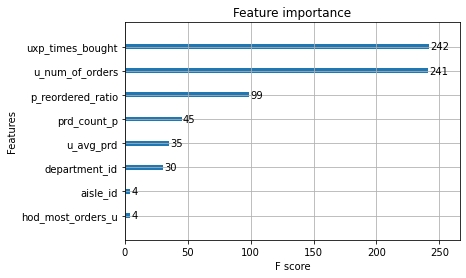

In [0]:
#FEATURE IMPORTANCE - GRAPHICAL
xgb.plot_importance(model)

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [0]:
# testing the model
y_pred = model.predict(X_test)
# Accuracy calculation
y_predit = model.predict(X_train)
print("Train Accuracy:",accuracy_score(y_train,y_predit))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Train Accuracy: 0.9065555432312329
Test Accuracy: 0.9066908852623055


In [0]:
#predicting on the testing data
y_pred = xgb_clf.predict(data_test).astype('int')

#setting a threshold.
y_pred = (xgb_clf.predict_proba(data_test)[:, 1] >= 0.21).astype('int')
y_pred[0:10]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [0]:
#saving the prediction as a new column in data_test
data_test['prediction'] = y_pred
data_test.head()

uxp_times_bought  ...  prediction
user_id product_id                    ...            
3       248                        1  ...           0
        1005                       1  ...           0
        1819                       3  ...           0
        7503                       1  ...           0
        8021                       1  ...           0

[5 rows x 11 columns]

In [0]:
# Reset the index
final = data_test.reset_index()
# Keep only the required columns to create our submission file (for chapter 6)
final = final[['product_id', 'user_id', 'prediction']]

final.head()

,product_id,user_id,prediction
0,248,3,0
1,1005,3,0
2,1819,3,0
3,7503,3,0
4,8021,3,0


In [0]:
#Creating a submission file
orders = pd.read_csv('/content/drive/My Drive/Project_8/Dataset/orders.csv')
orders_test = orders.loc[orders.eval_set == 'test', ['user_id', 'order_id']]
orders_test.head()

,user_id,order_id
38,3,2774568
44,4,329954
53,6,1528013
96,11,1376945
102,12,1356845


In [0]:
#merging our prediction with orders_test
final = final.merge(orders_test, on='user_id', how='left')
final.head()

,product_id,user_id,prediction,order_id
0,248,3,0,2774568
1,1005,3,0,2774568
2,1819,3,0,2774568
3,7503,3,0,2774568
4,8021,3,0,2774568


In [0]:
#remove user_id column
final = final.drop('user_id', axis=1)
#convert product_id as integer
final['product_id'] = final.product_id.astype(int)

## Remove all unnecessary objects
del orders
del orders_test

final.head()

,product_id,prediction,order_id
0,248,0,2774568
1,1005,0,2774568
2,1819,0,2774568
3,7503,0,2774568
4,8021,0,2774568


In [0]:
d = dict()
for row in final.itertuples():
    if row.prediction== 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in final.order_id:
    if order not in d:
        d[order] = 'None'
        

#We now check how the dictionary were populated (open hidden output)
d

{2774568: '9387 17668 21903 22035 39190 43961 47766',
 1528013: '21903 38293',
 1376945: '8309 8670 14947 27959 28465 33572 34658 35640 35948 42585 44632',
 1356845: '7076 10863 13176 14992 21616 28134',
 2161313: '196 10441 11266 12427 14715 27839 37710',
 1416320: '5134 17948 21137 21903 24852 28985 41950',
 1735923: '196 2192 5183 12108 14252 15131 17008 18174 24629 31487 33756 34690 35123',
 1980631: '6184 9387 13575 13914 22362 41400 46061',
 139655: '13176 21903 22935 24964 27845',
 1411408: '22008 43758',
 2940603: '7521 10339 14947 19894 30592 31615 44632',
 1192143: '24759 24852',
 3202221: '2452 4793 6069 7781 9203 9637 11130 13629 17630 21137 21927 24852 39911 45364 46979 49215',
 3222866: '7039 7969 8501 14947 15718 18894 32441 32912 33198 34254 35921 37131 38690',
 707453: '694 4942 6111 18150 21137 21267 21903 24852 26209 28156 32030 37766 39275 42585 44142 44830 45066 46802 47766 48230',
 1320132: '11079 44632',
 882556: '1870 5373 5450 7371 8424 9076 12857 17794 21903 2

In [0]:
#Convert the dictionary into a DataFrame
sub = pd.DataFrame.from_dict(d, orient='index')

#Reset index
sub.reset_index(inplace=True)
#Set column names
sub.columns = ['order_id', 'products']

sub.head()

,order_id,products
0,2774568,9387 17668 21903 22035 39190 43961 47766
1,1528013,21903 38293
2,1376945,8309 8670 14947 27959 28465 33572 34658 35640 ...
3,1356845,7076 10863 13176 14992 21616 28134
4,2161313,196 10441 11266 12427 14715 27839 37710


In [0]:
sub.sort_values(by=['order_id'], inplace=True)
sub.head()

,order_id,products
12956,17,13107 21463 21709 38777 47766
12342,34,39180 39475 47029 47766 47792
65649,137,2326 5134 23794 24852 25890 38689 41787 43352
40728,182,5479 9337 13629 21903 27104 33000 34243 35951 ...
12480,257,1025 4605 13870 21137 24852 27104 27966 28476 ...


In [0]:
new_df = pd.DataFrame(sub.products.str.split(' ').tolist(), index=sub.order_id).stack()
new_df = new_df.reset_index([0, 'order_id'])
new_df.columns = ['order_id', 'product_id']
new_df.head(10)

,order_id,product_id
0,17,13107
1,17,21463
2,17,21709
3,17,38777
4,17,47766
5,34,39180
6,34,39475
7,34,47029
8,34,47766
9,34,47792


In [0]:
orders = pd.read_csv('/content/drive/My Drive/Project_8/Dataset/orders.csv')
product=pd.read_csv('/content/drive/My Drive/Project_8/Dataset/products.csv')
df = pd.merge(orders,new_df,on = 'order_id',how = 'right')
df.drop(['eval_set', 'order_number','order_dow','order_hour_of_day','days_since_prior_order'], axis=1, inplace=True)
df.head()

,order_id,user_id,product_id
0,2774568,3,9387
1,2774568,3,17668
2,2774568,3,21903
3,2774568,3,22035
4,2774568,3,39190


In [0]:
df.replace(to_replace=['None'], value=0, inplace=True)
df["product_id"] = df["product_id"].astype(int)

In [0]:
result = pd.merge(df,product,on='product_id',how='left')
result.drop(['aisle_id', 'department_id'], axis=1, inplace=True)
result["product_name"].fillna("No products", inplace = True) 
result.head(20)

,order_id,user_id,product_id,product_name
0,2774568,3,9387,Granny Smith Apples
1,2774568,3,17668,Unsweetened Chocolate Almond Breeze Almond Milk
2,2774568,3,21903,Organic Baby Spinach
3,2774568,3,22035,Organic Whole String Cheese
4,2774568,3,39190,Vanilla Unsweetened Almond Milk
5,2774568,3,43961,Organic Peeled Whole Baby Carrots
6,2774568,3,47766,Organic Avocado
7,329954,4,0,No products
8,1528013,6,21903,Organic Baby Spinach
9,1528013,6,38293,Ground Turkey Breast


In [0]:
result.to_csv('result.csv', index=False)